In [2]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from generate_modes import *
import qnm

In [3]:
chi_f, M_f = 0.692, 0.9525
omegas_GR, taus_GR=[],[]
for n in range(8):
	qnm_mode = qnm.modes_cache(s=-2,l=2,m=2,n=n)
	omega_complex, _, _ = qnm_mode(a=chi_f)
	omega = np.real(omega_complex)/M_f
	tau=np.abs(1./np.imag(omega_complex))*M_f
	omegas_GR.append(omega)
	taus_GR.append(tau)
omegas=np.copy(omegas_GR)
taus=np.copy(taus_GR)

In [4]:
def damped_sine(t,tau, omega, phi, A):
	return A*np.exp(-t/tau)*np.cos(t*omega+phi)

In [5]:
def damped_sine_complex(t, phi, A, tau=taus[0], omega=omegas[0]):	
	t_real = t[:int(t.size/2)]
	t_imag = t[int(t.size/2):]
	real_out = A*np.exp(-t_real/tau)*np.cos(t_real*omega+phi)
	imag_out = -A*np.exp(-t_imag/tau)*np.sin(t_imag*omega+phi)
	return np.hstack([real_out, imag_out])

In [6]:
def damped_sine_complex_general(t, phi_c, phi_s, A_c, A_s, tau_c, tau_s, omega_c, omega_s):	
	t_real = t[:int(t.size/2)]
	t_imag = t[int(t.size/2):]
	real_out = A_c*np.exp(-t_real/tau_c)*np.cos(t_real/omega_c+phi_c)
	imag_out = -A_s*np.exp(-t_imag/tau_s)*np.sin(t_imag/omega_s+phi_s)
	return np.hstack([real_out, imag_out])

In [7]:
def damped_sine_complex_overtone(t, *p, taus=taus_GR, omegas=omegas_GR):
    n = int(len(p)/2)
    ns = np.arange(1,n+1,1)
    t_real = t[:int(t.size/2)]
    t_imag = t[int(t.size/2):]
    real_out=0.0
    imag_out=0.0
    phis = np.copy(p[:n])
    As = np.copy(p[n:])
    for (n, tau, omega, phi, A) in zip(ns, taus, omegas, phis, As):
        real_out += A*np.exp(-t_real/tau)*np.cos(t_real*omega+phi)
        imag_out += -A*np.exp(-t_imag/tau)*np.sin(t_imag*omega+phi)
    return np.hstack([real_out, imag_out])

In [8]:
def mismatch(htrue,hfit,t):
	htrue_hfit = np.trapz(np.real(htrue*np.conj(hfit)), x=t)
	htrue_htrue = np.trapz(np.abs(htrue)**2, x=t)
	hfit_hfit = np.trapz(np.abs(hfit)**2, x=t)
	return 1.-htrue_hfit/np.sqrt(htrue_htrue*hfit_hfit)

Prepare pure GR waveform

In [14]:
t_start = 0.0
strain_out=0.+0.j
time_GR, strain_22_GR = dCS_hlm(0.0,(2,2))
time_GR, strain_2m2_GR = dCS_hlm(0.0,(2,-2))
strain_22_GR*=1#SpinWeightedSphericalHarmonic(0.0, 0, -2, mode[0], mode[1])
t_RD_22_GR, h_RD_22_GR = get_ringdown(time_GR, strain_22_GR)
t_RD_GR = t_RD_22_GR[t_RD_22_GR>=t_start]
h_RD_GR = h_RD_22_GR[t_RD_22_GR>=t_start]
h_RD_vec_GR = np.hstack([np.real(h_RD_GR), np.imag(h_RD_GR)])
t_RD_2m2_GR, h_RD_2m2_GR = get_ringdown(time_GR, strain_2m2_GR)
mm_chiral=mismatch(h_RD_22_GR, np.conj(h_RD_2m2_GR), t_RD_22_GR)
print("mismatch between 22 and 2-2 is %g" %mm_chiral)

mismatch between 22 and 2-2 is 0


Fit with 8 overtones

[-1.93378366  0.23509446  2.98904053 -0.184075   -3.1415926
 -3.13601675  0.20923175 -2.81158852  0.96725288  4.01078605
  9.20315126 12.46746369  5.95705303  6.47289558  9.39134402
  3.26281144]
mismatch after the fit: 8.9407e-07


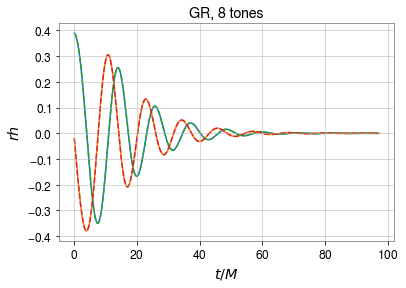

In [15]:
n=8
omegas=omegas_GR
taus=taus_GR
t_start = 0.0
t_RD_GR = t_RD_22_GR[t_RD_22_GR>=t_start]
h_RD_GR = h_RD_22_GR[t_RD_22_GR>=t_start]
h_RD_vec_GR = np.hstack([np.real(h_RD_GR), np.imag(h_RD_GR)])
t_GR = np.copy(t_RD_GR)
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone, np.hstack([t_RD_GR,t_RD_GR]), h_RD_vec_GR,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec_GR = damped_sine_complex_overtone(np.hstack([t_RD_GR,t_RD_GR]), *popt)
h_RD_fit_real_GR = h_RD_fit_vec_GR[:t_RD_GR.size]
h_RD_fit_imag_GR = h_RD_fit_vec_GR[t_RD_GR.size:]
h_RD_fit_GR = h_RD_fit_real_GR+h_RD_fit_imag_GR*1j
mm = mismatch(h_RD_GR, h_RD_fit_GR, t_RD_GR)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("GR, 8 tones")
plt.plot(t_RD_GR, np.real(h_RD_GR))
plt.plot(t_RD_GR, np.imag(h_RD_GR))
plt.plot(t_RD_GR, h_RD_fit_real_GR, ls='--')
plt.plot(t_RD_GR, h_RD_fit_imag_GR, ls='--')
plt.show()

[-1.91871417  0.96304312]
mismatch after the fit: 2.00868e-05


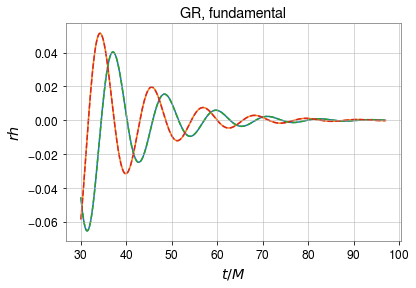

In [16]:
n=1
omegas=omegas_GR
taus=taus_GR
t_start = 30.0
t_RD_GR = t_RD_22_GR[t_RD_22_GR>=t_start]
h_RD_GR = h_RD_22_GR[t_RD_22_GR>=t_start]
h_RD_vec_GR = np.hstack([np.real(h_RD_GR), np.imag(h_RD_GR)])
t_GR = np.copy(t_RD_GR)
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone, np.hstack([t_RD_GR,t_RD_GR]), h_RD_vec_GR,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec_GR = damped_sine_complex_overtone(np.hstack([t_RD_GR,t_RD_GR]), *popt)
h_RD_fit_real_GR = h_RD_fit_vec_GR[:t_RD_GR.size]
h_RD_fit_imag_GR = h_RD_fit_vec_GR[t_RD_GR.size:]
h_RD_fit_GR = h_RD_fit_real_GR+h_RD_fit_imag_GR*1j
mm = mismatch(h_RD_GR, h_RD_fit_GR, t_RD_GR)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("GR, fundamental")
plt.plot(t_RD_GR, np.real(h_RD_GR))
plt.plot(t_RD_GR, np.imag(h_RD_GR))
plt.plot(t_RD_GR, h_RD_fit_real_GR, ls='--')
plt.plot(t_RD_GR, h_RD_fit_imag_GR, ls='--')
plt.show()

In [18]:
ell=0.3
t_start = 0.0
strain_out=0.+0.j
time_dCS, strain_22_dCS = dCS_hlm(ell,(2,2))
time_dCS, strain_2m2_dCS = dCS_hlm(ell,(2,-2))
strain_22_dCS*=1#SpinWeightedSphericalHarmonic(0.0, 0, -2, mode[0], mode[1])
t_RD_22_dCS, h_RD_22_dCS = get_ringdown(time_dCS, strain_22_dCS)
t_RD_dCS = t_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_dCS = h_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_vec_dCS = np.hstack([np.real(h_RD_dCS), np.imag(h_RD_dCS)])
t_RD_2m2_dCS, h_RD_2m2_dCS = get_ringdown(time_dCS, strain_2m2_dCS)
mm_chiral=mismatch(h_RD_22_dCS, np.conj(h_RD_2m2_dCS), t_RD_22_dCS)
print("mismatch between 22 and 2-2 is %g" %mm_chiral)

mismatch between 22 and 2-2 is 1.19209e-07


[-0.24558287  2.13255796 -1.01088848  2.40398903 -0.43251077
 -3.14159254 -3.14159258  0.17235958  1.08522669  3.79383231
  9.65278641 18.08574279 17.39139142  1.53348662  9.3088658
  4.52349377]
mismatch after the fit: 1.96099e-05


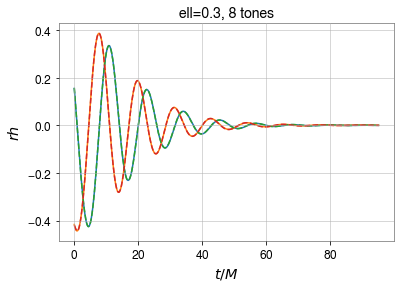

In [20]:
n=8
omegas=omegas_GR
taus=taus_GR
t_start = 0.0
t_RD_dCS = t_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_dCS = h_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_vec_dCS = np.hstack([np.real(h_RD_dCS), np.imag(h_RD_dCS)])
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone, np.hstack([t_RD_dCS,t_RD_dCS]), h_RD_vec_dCS,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec_dCS = damped_sine_complex_overtone(np.hstack([t_RD_dCS,t_RD_dCS]), *popt)
h_RD_fit_real_dCS = h_RD_fit_vec_dCS[:t_RD_dCS.size]
h_RD_fit_imag_dCS = h_RD_fit_vec_dCS[t_RD_dCS.size:]
h_RD_fit_dCS = h_RD_fit_real_dCS+h_RD_fit_imag_dCS*1j
mm = mismatch(h_RD_dCS, h_RD_fit_dCS, t_RD_dCS)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("ell=0.3, 8 tones")
plt.plot(t_RD_dCS, np.real(h_RD_dCS))
plt.plot(t_RD_dCS, np.imag(h_RD_dCS))
plt.plot(t_RD_dCS, h_RD_fit_real_dCS, ls='--')
plt.plot(t_RD_dCS, h_RD_fit_imag_dCS, ls='--')
plt.show()

[-0.26602802  1.08470155]
mismatch after the fit: 0.000319362


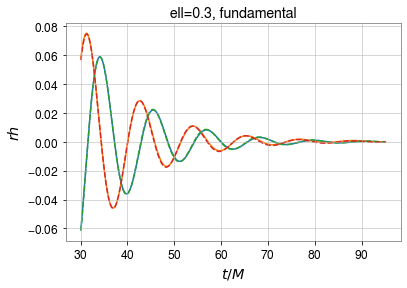

In [22]:
n=1
omegas=omegas_GR
taus=taus_GR
t_start = 30.0
t_RD_dCS = t_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_dCS = h_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_vec_dCS = np.hstack([np.real(h_RD_dCS), np.imag(h_RD_dCS)])
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone, np.hstack([t_RD_dCS,t_RD_dCS]), h_RD_vec_dCS,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec_dCS = damped_sine_complex_overtone(np.hstack([t_RD_dCS,t_RD_dCS]), *popt)
h_RD_fit_real_dCS = h_RD_fit_vec_dCS[:t_RD_dCS.size]
h_RD_fit_imag_dCS = h_RD_fit_vec_dCS[t_RD_dCS.size:]
h_RD_fit_dCS = h_RD_fit_real_dCS+h_RD_fit_imag_dCS*1j
mm = mismatch(h_RD_dCS, h_RD_fit_dCS, t_RD_dCS)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("ell=0.3, fundamental")
plt.plot(t_RD_dCS, np.real(h_RD_dCS))
plt.plot(t_RD_dCS, np.imag(h_RD_dCS))
plt.plot(t_RD_dCS, h_RD_fit_real_dCS, ls='--')
plt.plot(t_RD_dCS, h_RD_fit_imag_dCS, ls='--')
plt.show()

In [27]:
def damped_sine_complex_overtone_perturb(t, *p, taus=taus_GR, omegas=omegas_GR):
    n = int(len(p)/4)
    ns = np.arange(1,n+1,1)
    t_real = t[:int(t.size/2)]
    t_imag = t[int(t.size/2):]
    real_out=0.0
    imag_out=0.0
    phis = np.copy(p[:n])
    As = np.copy(p[n:2*n])
    dtaus = np.copy(p[2*n:3*n])
    domegas = np.copy(p[3*n:])
    for (n, tau, omega, phi, A, dtau, domega) in zip(ns, taus, omegas, phis, As, dtaus, domegas):
        real_out += A*np.exp(-t_real/tau/(1.0+dtau))*np.cos(t_real*omega*(1.0+domega)+phi)
        imag_out += -A*np.exp(-t_imag/tau/(1.0+dtau))*np.sin(t_imag*omega*(1.0+domega)+phi)
    return np.hstack([real_out, imag_out])

0.551754358178708 11.683486432520054
[-0.13268593  1.10293196]
mismatch after the fit: 6.05583e-05


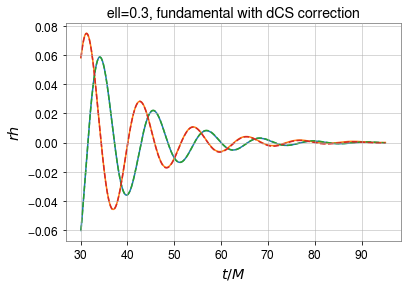

In [24]:
omegas=np.copy(omegas_GR)
taus=np.copy(taus_GR)
omegas[0]+=-0.437*ell**4/M_f
omegas[1]+=3.92*ell**4/M_f
omegas[2]+=-1.54*ell**4/M_f
taus[0]+=-8.13*ell**4*M_f
taus[1]+=220.1*ell**4*M_f
taus[2]+=-146.9*ell**4*M_f
print(omegas[0],taus[0])
n=1
t_start = 30.0
t_RD_dCS = t_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_dCS = h_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_vec_dCS = np.hstack([np.real(h_RD_dCS), np.imag(h_RD_dCS)])
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
damped_sine_complex_overtone_dCS = lambda t,*p: damped_sine_complex_overtone(t,*p,taus=taus,omegas=omegas)
popt,pcov = curve_fit(damped_sine_complex_overtone_dCS, np.hstack([t_RD_dCS,t_RD_dCS]), h_RD_vec_dCS,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec_dCS = damped_sine_complex_overtone_dCS(np.hstack([t_RD_dCS,t_RD_dCS]), *popt)
h_RD_fit_real_dCS = h_RD_fit_vec_dCS[:t_RD_dCS.size]
h_RD_fit_imag_dCS = h_RD_fit_vec_dCS[t_RD_dCS.size:]
h_RD_fit_dCS = h_RD_fit_real_dCS+h_RD_fit_imag_dCS*1j
mm = mismatch(h_RD_dCS, h_RD_fit_dCS, t_RD_dCS)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("ell=0.3, fundamental with dCS correction")
plt.plot(t_RD_dCS, np.real(h_RD_dCS))
plt.plot(t_RD_dCS, np.imag(h_RD_dCS))
plt.plot(t_RD_dCS, h_RD_fit_real_dCS, ls='--')
plt.plot(t_RD_dCS, h_RD_fit_imag_dCS, ls='--')
plt.show()

[-3.75025471  3.47341308 -3.20607714  1.10837122  0.4027706
 -1.46503967 -0.43822336  0.04679486  3.77429295  0.04167384
 -0.26258691  0.0585676 ]
[11.746211415020055, 3.8848764218587917, 2.3008360501480563] [0.5554705786511489, 0.5432084040881462, 0.5204940465036484]
[ 6.59874718  4.06666866 10.98486532] [0.57861917 0.40056899 0.55097813]
[0.56177664 1.04679486 4.77429295] [1.04167384 0.73741309 1.0585676 ]
mismatch after the fit: 1.60933e-06


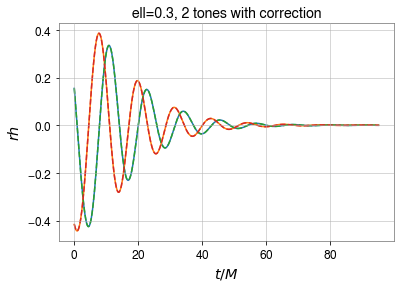

In [48]:
n=3
t_start = 0.0
t_RD_dCS = t_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_dCS = h_RD_22_dCS[t_RD_22_dCS>=t_start]
h_RD_vec_dCS = np.hstack([np.real(h_RD_dCS), np.imag(h_RD_dCS)])
p0_phis=[np.pi/6.0]*n
p0_As=np.linspace(1,n+1,n)
p0_dtaus=[0.01]*n
p0_domegas=[0.01]*n
p0=np.array([p0_phis,p0_As,p0_dtaus,p0_domegas]).flatten()
#plow=np.array([[-2.*np.pi]*n,[1.e-3]*n,[-0.25]*n,[-0.25]*n]).flatten()
#pup=np.array([[2.*np.pi]*n,[10**n]*n,[0.25]*n,[0.25]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone_perturb, np.hstack([t_RD_dCS,t_RD_dCS]), h_RD_vec_dCS,p0=p0, maxfev=10000)#, bounds = (plow,pup))
print(popt)
print(taus_GR[:n], omegas_GR[:n])
print(taus_GR[:n]*(1.+popt[2*n:3*n]), omegas_GR[:n]*(1.+popt[3*n:]))
print((1.+popt[2*n:3*n]), (1.+popt[3*n:]))

h_RD_fit_vec_dCS = damped_sine_complex_overtone_perturb(np.hstack([t_RD_dCS,t_RD_dCS]), *popt)
h_RD_fit_real_dCS = h_RD_fit_vec_dCS[:t_RD_dCS.size]
h_RD_fit_imag_dCS = h_RD_fit_vec_dCS[t_RD_dCS.size:]
h_RD_fit_dCS = h_RD_fit_real_dCS+h_RD_fit_imag_dCS*1j
mm = mismatch(h_RD_dCS, h_RD_fit_dCS, t_RD_dCS)
print("mismatch after the fit: %.6g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("ell=0.3, 2 tones with correction")
plt.plot(t_RD_dCS, np.real(h_RD_dCS))
plt.plot(t_RD_dCS, np.imag(h_RD_dCS))
plt.plot(t_RD_dCS, h_RD_fit_real_dCS, ls='--')
plt.plot(t_RD_dCS, h_RD_fit_imag_dCS, ls='--')
plt.show()